# Demo of Build tools from SwiftPol

- Build a short linear co-polymer chain (PLGA)
- Create a small SwiftPol PLGA ensemble, assign partial charges to the chain, and inspect the chains in the system
- Solvate the PLGA ensemble with water, NaCl and residual monomer
- Build a [syndiotactic](https://pubs.acs.org/doi/10.1021/cr040002s) PLA chain

In [1]:
# Print SwiftPol Version
from swiftpol.__version__ import __version__
__version__

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


'0.1.2'

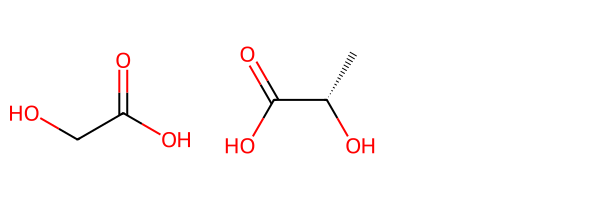

In [2]:
# Import monomers to build PLGA and visualise using RDkit
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   
monomer_smiles = ['OC(=O)CO', 'C[C@@H](C(=O)[OH])O']
glycolic = Chem.MolFromSmiles(monomer_smiles[0])
lactate = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic,lactate])

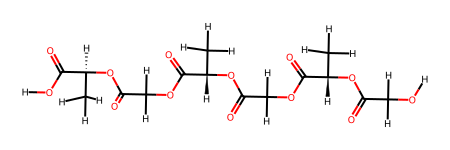

In [3]:
# Build a short linear chain using Swiftpol
from swiftpol import build
from rdkit.Chem import AllChem
monomer_list = ['OC(=O)COI', 'C[C@@H](C(=O)[OH])OI']
reaction = AllChem.ReactionFromSmarts('[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]')
chain = build.build_polymer(sequence = 'ABABAB',
                            monomer_list= monomer_list,
                            reaction = reaction)
chain

In [4]:
# Build a PLGA system
from rdkit.Chem import AllChem
polymer = build.polymer_system(monomer_list = ['OC(=O)COI', 'C[C@@H](C(=O)[OH])OI'],
                               reaction = '[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]',
                               length_target=10,
                               num_chains = 8,
                               terminals='hydroxyl',
                               blockiness_target=[1.0, 'B'],
                               perc_A_target=50, 
                               copolymer=True,
                               acceptance=5)

# Calculate the polydispersity index of the PLGA system
PDI = build.PDI(polymer.chain_rdkit)[0]
print('PDI = ', PDI)

System built!, size = 8
PDI =  1.0


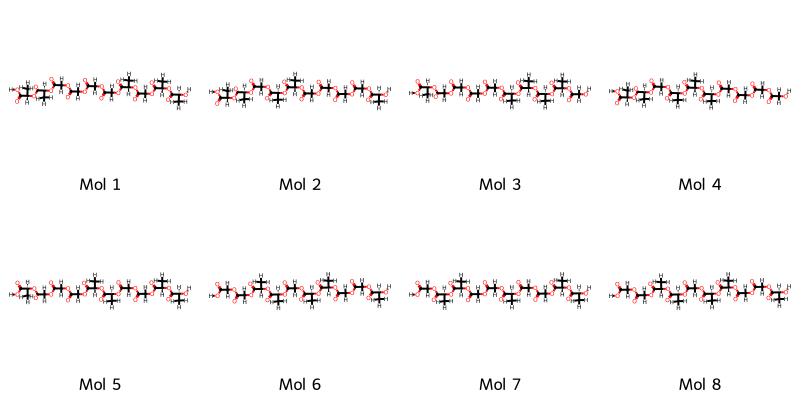

In [5]:
# Generate a grid image of the molecules
from rdkit.Chem import Draw
Draw.MolsToGridImage(
    polymer.chain_rdkit,
    molsPerRow=4,  # Number of molecules per row
    subImgSize=(200, 200),  # Size of each molecule image
    legends=[f"Mol {i+1}" for i in range(len(polymer.chain_rdkit))]  # Optional legends
)

In [6]:
# Calculate the blockiness of the sequence
from swiftpol import build
mean_blockiness, G_block_length, L_block_length = build.blockiness_gen(sequence=polymer.sequence, wrt='B')
print("Average chain blockiness =", round(mean_blockiness,1))
print("G Block length =", round(G_block_length))
print("L Block length =", round(L_block_length))

Average chain blockiness = 1.0
G Block length = 2
L Block length = 2


In [7]:
# Charge the PLGA system using OpenFF NAGL 
polymer.charge_system('NAGL')

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [8]:
# Generate conformers and inspect first chain in 3D (requires nglview)
polymer.generate_conformers()
polymer.chains[0].visualize('nglview')

LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


NGLWidget()

In [11]:
# Use the OpenFF Packmol Wrapper to solvate the chains
# Example of using existing tools to prepare SwiftPol chains for Molecular Dynamics
from openff.units import unit
molecules, number_of_copies, topology, box_vectors, residual_monomer_actual = build.calculate_box_components(chains = polymer.chains, 
                                                                                                       monomers = polymer.monomers, 
                                                                                                       sequence = polymer.sequence, 
                                                                                                       salt_concentration= 1 * unit.mole/unit.litre,
                                                                                                       residual_monomer = 10,
                                                                                                       solvated=True)
print(f'residual monomer = {round(residual_monomer_actual,2)}%')
import openff.interchange.components._packmol as packmol_wrapper
solvated_top = packmol_wrapper.pack_box(molecules = molecules + polymer.chains,
                                        number_of_copies = number_of_copies+[1 for i in range(len(polymer.chains))],
                                        box_vectors = box_vectors,
                                        tolerance = 1*unit.angstrom)
solvated_top.visualize()

residual monomer = 7.04%


NGLWidget()

In [13]:
# Perform the same function using the SwiftPol ensemble class function
solvated_top_swiftpol = polymer.pack_solvated_system(salt_concentration= 1 * unit.mole/unit.litre, residual_monomer = 10)
print(f'residual monomer = {round(polymer.residual_monomer_actual,2)}%')
solvated_top_swiftpol.visualize()

residual monomer = 7.04%


NGLWidget()

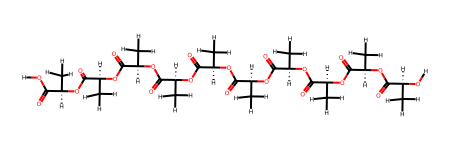

In [14]:
# Create a syndiotactic PLA chain
build.build_polymer(sequence = 'ABABABABAB',
                    monomer_list = ['C[C@@H](C(=O)[OH])OI', 'C[C@H](C(=O)[OH])OI'],
                    reaction = AllChem.ReactionFromSmarts('[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]'))


In [15]:
# Build a PLA system with a target PDI
from rdkit.Chem import AllChem
from swiftpol import build
polymer = build.polymer_system_from_PDI(monomer_list=['OC(=O)COI'], 
                            reaction = '[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]', 
                            length_target= 50, 
                            num_chains=50,
                            PDI_target=1.7,
                            copolymer=False,
                            acceptance=10)

# Calculate the polydispersity index of the PLGA system
PDI = build.PDI(polymer.chain_rdkit)[0]
print('PDI = ', PDI)

System built!, size = 50
PDI =  1.638965358621101
